# Assistant IA de préselection de CV 

In [1]:
import os
import spacy
import random
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from spacy.tokens import DocBin
from datasets import load_dataset
from sklearn.utils import resample
from spacy.training import Example
from spacy.util import minibatch, compounding
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from lime.lime_text import LimeTextExplainer

In [2]:
dataset = load_dataset("cnamuangtoun/resume-job-description-fit")

In [3]:
df=pd.DataFrame(dataset["train"])
df.head()

,resume_text,job_description_text,label
0,SummaryHighly motivated Sales Associate with e...,Net2Source Inc. is an award-winning total work...,No Fit
1,Professional SummaryCurrently working with Cat...,At Salas OBrien we tell our clients that were ...,No Fit
2,SummaryI started my construction career in Jun...,Schweitzer Engineering Laboratories (SEL) Infr...,No Fit
3,SummaryCertified Electrical Foremanwith thirte...,"Mizick Miller & Company, Inc. is looking for a...",No Fit
4,SummaryWith extensive experience in business/r...,Life at Capgemini\nCapgemini supports all aspe...,No Fit


In [4]:
dt=pd.DataFrame(dataset["test"])
dt.head()

,resume_text,job_description_text,label
0,Summary7+ years of experience as a BI develope...,Key Responsibilities:Create intricate wiring n...,No Fit
1,Professional BackgroundAnalyst versed in data ...,Personal development and becoming the best you...,No Fit
2,Executive ProfileDedicated professional with t...,"Location: Tampa, FL\nExp: 7-10 Yrs\nSPOC: Tush...",No Fit
3,"Summarytyee\nHighlightsMicrosoft Excel, Word, ...","Primary Location: Melbourne, Florida\nV-Soft C...",No Fit
4,SummaryEIT certified Engineer and ASTQB Certif...,At Oregon Specialty Group the Accounting & Pay...,No Fit


In [5]:
df['resume_text'][0]

"SummaryHighly motivated Sales Associate with extensive customer service and sales experience. Outgoing sales professional with track record of driving increased sales, improving buying experience and elevating company profile with target market.\nHighlights-Soft Skills: Public Speaking, Public Relations, Team Building, Project Management, Procedure writing, Staff Supervision and Management, Ability to interface with professionals on all levels. Accomplishments, Honors, and Activities -Board of Directors Member for the Food Bank of Corpus Christi from November 2010 to April 2013. -Held Life Insurance License -Basketball Official (Referee) High School Varsity Level.\nExperienceAccountant,08/2014-05/2015Aspirus–Owen,WI,Perform daily and routine accounting functions for two main companies and five small royalty companies. Responsibilities include but are not limited to the following: Accounts Payable, Accounts Receivable, Manage and reconcile funds for multiple banks accounts, Payroll, Pe

In [6]:
df['job_description_text'][0]

"Net2Source Inc. is an award-winning total workforce solutions company recognized by Staffing Industry Analysts for our accelerated growth of 300% in the last 3 years with over 5500+ employees globally, with over 30+ locations in the US and global operations in 32 countries. We believe in providing staffing solutions to address the current talent gap  Right Talent  Right Time  Right Place  Right Price and acting as a Career Coach to our consultants.  \nRole: Basel Business AnalystLocation: Washington, D.C.Work Mode: HybridHire Type: 6+ Month Contract (extendable)\nJD: Role Specific Experience: 6+ years of relevant technical and business work experience The Candidates who have worked on Basel related projects in Credit risks or at least are aware of credit risk.  Banking & Financial domain experience, along with knowledge of risk management, familiarity with concepts of finance and accounting  Proficiency in MS Excel  Experience in defining and implementing technology solutions for a ma

In [7]:
print("\nMissing Values:")
print(df.isnull().sum())
print("\nDuplicates:")
print(df.duplicated().sum())


Missing Values:
resume_text             0
job_description_text    0
label                   0
dtype: int64

Duplicates:
1


In [8]:
df= df.drop_duplicates()

In [9]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [10]:
len(df)

6240

In [11]:
len(dt)

1759

In [12]:
df['label'].value_counts()

label
No Fit           3142
Potential Fit    1556
Good Fit         1542
Name: count, dtype: int64

In [13]:
df_no_fit_downsampled = resample(df[df['label'] == 'No Fit'], 
                                replace=False, 
                                n_samples=1550, 
                                random_state=42)
df = pd.concat([
    df_no_fit_downsampled,
    df[df['label'] == 'Potential Fit'],
    df[df['label'] == 'Good Fit']
])

In [14]:
df['label'].value_counts()

label
Potential Fit    1556
No Fit           1550
Good Fit         1542
Name: count, dtype: int64

In [15]:
dt['label'].value_counts()
dt_no_fit_downsampled = resample(dt[dt['label'] == 'No Fit'], 
                                replace=False, 
                                n_samples=450, 
                                random_state=42)
dt = pd.concat([
    dt_no_fit_downsampled,
    dt[dt['label'] == 'Potential Fit'],
    dt[dt['label'] == 'Good Fit']
])

In [16]:
dt['label'].value_counts()

label
Good Fit         458
No Fit           450
Potential Fit    444
Name: count, dtype: int64

In [17]:
print(len(df), len(dt))

4648 1352


In [18]:
label_map = {
        'Good Fit': 2,
        'Potential Fit': 1,
        'No Fit': 0
    }
df['label_num'] = df['label'].map(label_map)
dt['label_num'] = dt['label'].map(label_map)

In [19]:
train_df, test_df = train_test_split(
        df, test_size=0.2, random_state=RANDOM_SEED, stratify=df['label']
    )
class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_df['label_num']),
        y=train_df['label_num']
    )
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print("\nClass weights for handling imbalance:")
print(f"No Fit: {class_weight_dict[0]:.4f}")
print(f"Potential Fit: {class_weight_dict[1]:.4f}")
print(f"Good Fit: {class_weight_dict[2]:.4f}")


Class weights for handling imbalance:
No Fit: 0.9995
Potential Fit: 0.9954
Good Fit: 1.0051


In [20]:
df['resume_job'] = df['resume_text'] + " [SEP] " + df['job_description_text']

In [21]:
dt['resume_job'] = dt['resume_text'] + " [SEP] " + dt['job_description_text']

In [22]:
try:
    nlp= spacy.load("en_core_web_sm")
    print("spaCy model 'en_core_web_sm' loaded successfully.")
except OSError:
    print("spaCy model 'en_core_web_sm' not found")
    nlp = None 

spaCy model 'en_core_web_sm' loaded successfully.


In [23]:
def prepare_data(df,nlp):
    doc_bin=DocBin()
    for _, row in tqdm(df.iterrows(), total=len(df),desc="converting text to docs"):
        doc=nlp.make_doc(row['resume_job'])
        if row['label_num'] == 0: 
            doc.cats = {'NO_FIT': 1.0, 'POTENTIAL_FIT': 0.0, 'GOOD_FIT': 0.0}
        elif row['label_num'] == 1:  
            doc.cats = {'NO_FIT': 0.0, 'POTENTIAL_FIT': 1.0, 'GOOD_FIT': 0.0}
        else:  
            doc.cats = {'NO_FIT': 0.0, 'POTENTIAL_FIT': 0.0, 'GOOD_FIT': 1.0}
            
        doc_bin.add(doc)
    return doc_bin

In [24]:
train_doc=prepare_data(df, nlp)
val_doc=prepare_data(dt, nlp)

converting text to docs: 100%|██████████| 1352/1352 [00:07<00:00, 191.96it/s]


In [25]:
def train_model(dft, valdf, class_weights, n_iter=10):
    nlp = spacy.blank("en")
    
    config = {
        "threshold": 0.5,
        "model": {
            "@architectures": "spacy.TextCatEnsemble.v2",
            "tok2vec": {
                "@architectures": "spacy.Tok2Vec.v2",
                "embed": {
                    "@architectures": "spacy.MultiHashEmbed.v2",
                    "width": 64,
                    "rows": [2000, 2000, 2000, 2000, 2000],
                    "attrs": ["ORTH", "LOWER", "PREFIX", "SUFFIX", "SHAPE"],
                    "include_static_vectors": False
                },
                "encode": {
                    "@architectures": "spacy.MaxoutWindowEncoder.v2",
                    "width": 64,
                    "window_size": 1,
                    "maxout_pieces": 3,
                    "depth": 2
                }
            },
            "linear_model": {
                "@architectures": "spacy.TextCatBOW.v3",
                "exclusive_classes": True,
                "length": 262144,
                "ngram_size": 1,
                "no_output_layer": False
            }
        }
    }
    
    textcat = nlp.add_pipe("textcat", config=config)
    
    labels = ["NO_FIT", "POTENTIAL_FIT", "GOOD_FIT"]
    for label in labels:
        textcat.add_label(label)

    train_docs = list(dft.get_docs(nlp.vocab))
    val_docs = list(valdf.get_docs(nlp.vocab))
    
    train_examples = [Example.from_dict(nlp.make_doc(doc.text), {"cats": doc.cats}) 
                     for doc in train_docs]

    textcat.initialize(lambda: train_examples, nlp=nlp)
    
    dropout = 0.2
    batch_sizes = compounding(4.0, 32.0, 1.001)
    
    train_losses = []
    val_metrics = {'accuracy': [], 'f1': {label: [] for label in labels}}

    optimizer = nlp.resume_training()
    for epoch in range(n_iter):
        random.shuffle(train_examples)
        losses = {}
        
        weighted_examples = []
        for example in train_examples:
            cats = example.reference.cats
            dominant_label = max(cats.items(), key=lambda x: x[1])[0]
            
            label_index = {"NO_FIT": 0, "POTENTIAL_FIT": 1, "GOOD_FIT": 2}[dominant_label]
            weight = class_weights[label_index]
            weighted_examples.extend([example] * max(1, int(weight)))
        
        batches = minibatch(weighted_examples, size=batch_sizes)
        for batch in batches:
            nlp.update(batch, drop=dropout, losses=losses, sgd=optimizer)
        
        
        train_loss = losses.get('textcat', 0.0)
        train_losses.append(train_loss)
        
        correct = 0
        total = len(val_docs)
        f1_counts = {label: {'tp': 0, 'fp': 0, 'fn': 0} for label in labels}
        
        for val_doc in val_docs:
            pred_doc = nlp(val_doc.text)
            true_label = max(val_doc.cats.items(), key=lambda x: x[1])[0]
            pred_label = max(pred_doc.cats.items(), key=lambda x: x[1])[0]
            
            correct += int(true_label == pred_label)
            
            for label in labels:
                if true_label == label and pred_label == label:
                    f1_counts[label]['tp'] += 1
                elif pred_label == label:
                    f1_counts[label]['fp'] += 1
                elif true_label == label:
                    f1_counts[label]['fn'] += 1
        
        val_accuracy = correct / total if total > 0 else 0
        val_metrics['accuracy'].append(val_accuracy)
        
        epoch_f1 = {}
        for label in labels:
            tp = f1_counts[label]['tp']
            fp = f1_counts[label]['fp']
            fn = f1_counts[label]['fn']
            
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
            
            epoch_f1[label] = f1
            val_metrics['f1'][label].append(f1)
        
        print(f"\nEpoch {epoch+1}/{n_iter}")
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Val Accuracy: {val_accuracy:.4f}")
        print("F1 Scores:")
        for label in labels:
            print(f"  {label}: {epoch_f1[label]:.4f}")
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(train_losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    
    plt.subplot(1, 3, 2)
    plt.plot(val_metrics['accuracy'])
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    
    plt.subplot(1, 3, 3)
    for label in labels:
        plt.plot(val_metrics['f1'][label], label=label)
    plt.title('Validation F1 Scores')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return nlp


Epoch 1/20
Train Loss: 175.9433
Val Accuracy: 0.3528
F1 Scores:
  NO_FIT: 0.2229
  POTENTIAL_FIT: 0.4980
  GOOD_FIT: 0.1246

Epoch 2/20
Train Loss: 76.4407
Val Accuracy: 0.3876
F1 Scores:
  NO_FIT: 0.3817
  POTENTIAL_FIT: 0.4492
  GOOD_FIT: 0.3171

Epoch 3/20
Train Loss: 47.7885
Val Accuracy: 0.3905
F1 Scores:
  NO_FIT: 0.4626
  POTENTIAL_FIT: 0.2000
  GOOD_FIT: 0.4195

Epoch 4/20
Train Loss: 34.5210
Val Accuracy: 0.4105
F1 Scores:
  NO_FIT: 0.4482
  POTENTIAL_FIT: 0.3711
  GOOD_FIT: 0.4050

Epoch 5/20
Train Loss: 26.5403
Val Accuracy: 0.3905
F1 Scores:
  NO_FIT: 0.4368
  POTENTIAL_FIT: 0.4231
  GOOD_FIT: 0.2784

Epoch 6/20
Train Loss: 21.5894
Val Accuracy: 0.3713
F1 Scores:
  NO_FIT: 0.4805
  POTENTIAL_FIT: 0.3219
  GOOD_FIT: 0.1834

Epoch 7/20
Train Loss: 19.5536
Val Accuracy: 0.4216
F1 Scores:
  NO_FIT: 0.4684
  POTENTIAL_FIT: 0.4198
  GOOD_FIT: 0.3583

Epoch 8/20
Train Loss: 19.4211
Val Accuracy: 0.4238
F1 Scores:
  NO_FIT: 0.4667
  POTENTIAL_FIT: 0.3711
  GOOD_FIT: 0.4239

Epoch 

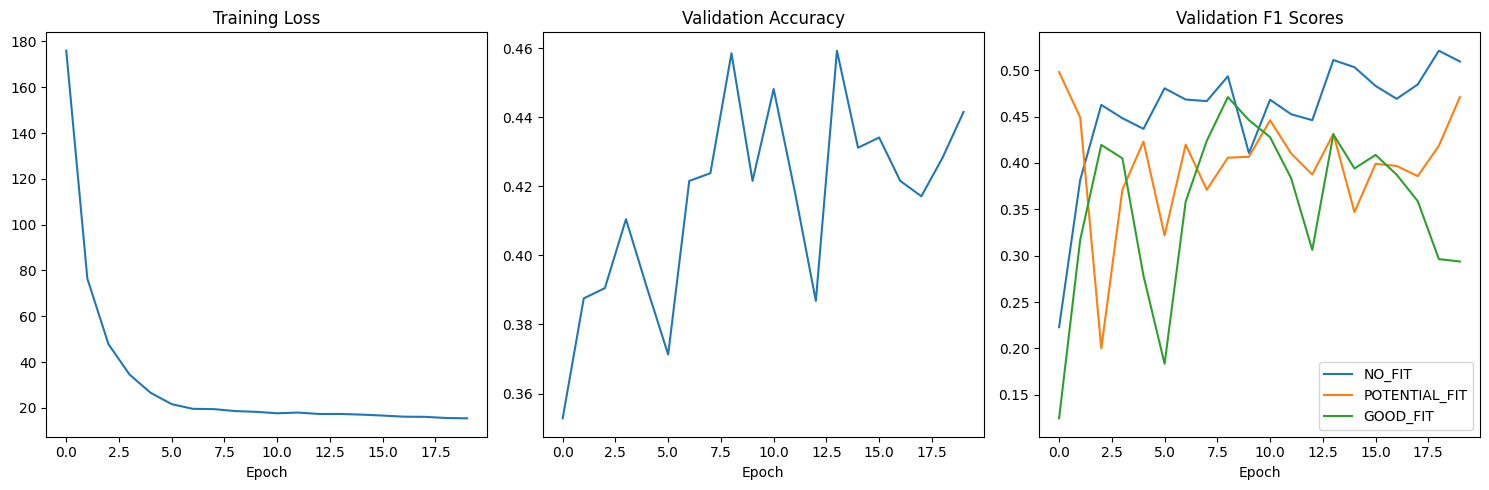

In [26]:
trained_model = train_model(train_doc, val_doc, class_weight_dict,20)

In [27]:
def evaluation(model, test_df):
    label_map = {
        0: "NO_FIT",
        1: "POTENTIAL_FIT",
        2: "GOOD_FIT"
    }
    
    y_true = [label_map[label] for label in test_df['label_num'].tolist()]
    y_pred = []
    
    for text in tqdm(test_df['resume_job'], desc="Evaluating test set"):
        doc = model(text)
        pred_label = max(doc.cats.items(), key=lambda x: x[1])[0]
        y_pred.append(pred_label)
    
    accuracy = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred)
    cm = confusion_matrix(
        y_true, y_pred, 
        labels=["NO_FIT", "POTENTIAL_FIT", "GOOD_FIT"]
    )
    
    return {
        "accuracy": accuracy,
        "report": classification_report(y_true, y_pred, output_dict=True),
        "confusion_matrix": cm
    }

In [28]:
res_eval=evaluation(trained_model, dt)

Evaluating test set: 100%|██████████| 1352/1352 [00:22<00:00, 60.67it/s]



Test Set Evaluation:
Accuracy: 0.4416

Classification Report:
{'GOOD_FIT': {'precision': 0.4484304932735426, 'recall': 0.2183406113537118, 'f1-score': 0.2936857562408223, 'support': 458.0}, 'NO_FIT': {'precision': 0.43890675241157556, 'recall': 0.6066666666666667, 'f1-score': 0.5093283582089553, 'support': 450.0}, 'POTENTIAL_FIT': {'precision': 0.4418145956607495, 'recall': 0.5045045045045045, 'f1-score': 0.47108307045215564, 'support': 444.0}, 'accuracy': 0.4415680473372781, 'macro avg': {'precision': 0.44305061378195587, 'recall': 0.443170594174961, 'f1-score': 0.4246990616339777, 'support': 1352.0}, 'weighted avg': {'precision': 0.4430879326759351, 'recall': 0.4415680473372781, 'f1-score': 0.42371798878186656, 'support': 1352.0}}


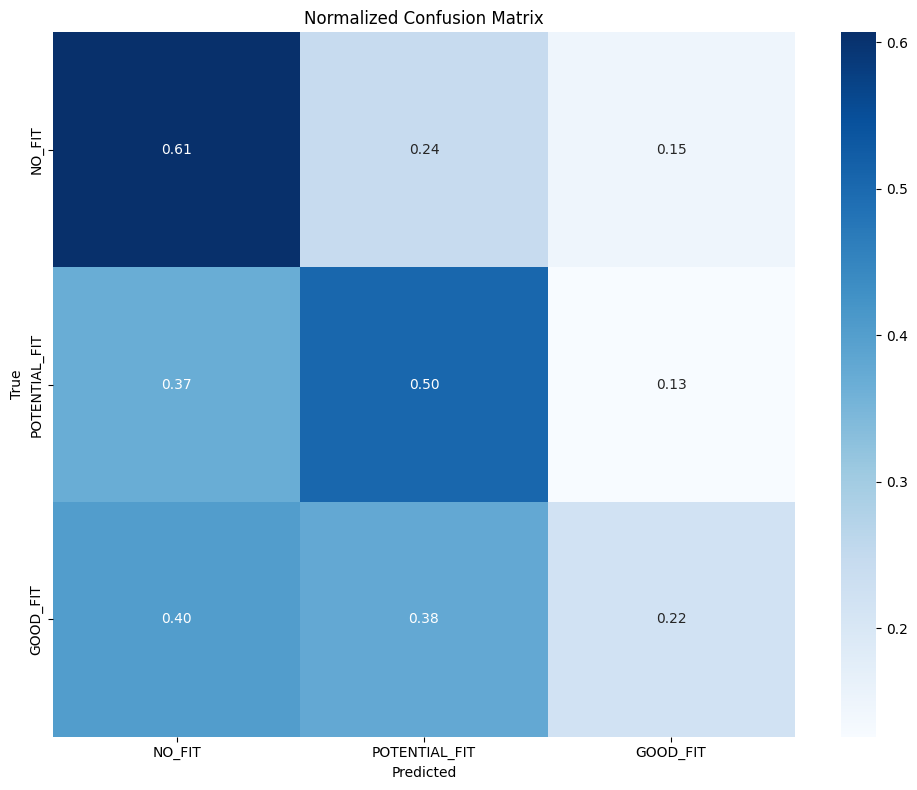

In [29]:
print("\nTest Set Evaluation:")
print(f"Accuracy: {res_eval['accuracy']:.4f}")
print("\nClassification Report:")
print(res_eval['report'])

    
plt.figure(figsize=(10, 8))
cm_normalized = res_eval['confusion_matrix'].astype('float') / res_eval['confusion_matrix'].sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', 
        xticklabels=["NO_FIT", "POTENTIAL_FIT", "GOOD_FIT"], 
        yticklabels=["NO_FIT", "POTENTIAL_FIT", "GOOD_FIT"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.tight_layout()
plt.show()

In [30]:
def prediction(nlp_model, resume_text, job_description_text):
    combined_text = resume_text + " [SEP] " + job_description_text
    doc = nlp_model(combined_text)

    pred_label=max(doc.cats.items(), key=lambda x: x[1])[0]
    label_map_inv = {
        "NO_FIT": "No Fit",
        "POTENTIAL_FIT": "Potential Fit",
        "GOOD_FIT": "Good Fit"
    }
    return label_map_inv[pred_label], doc.cats

In [31]:
def predictor_for_lime(texts):
    docs = [trained_model(text) for text in texts]
    
    labels = trained_model.get_pipe("textcat").labels
    
    probas = []
    for doc in docs:
        scores = {label: doc.cats.get(label, 0.0) for label in labels}
        total = sum(scores.values())
        if total > 0:
            normalized_scores = [scores[label] / total for label in labels]
        else:
            normalized_scores = [1.0 / len(labels)] * len(labels) 
        probas.append(normalized_scores)
    return np.array(probas)

In [32]:
class_names = ["No Fit", "Potential Fit", "Good Fit"]
explainer = LimeTextExplainer(class_names=class_names)

sample_idx = 1000  
sample_resume = dt["resume_text"].iloc[sample_idx]
sample_job_desc = dt["job_description_text"].iloc[sample_idx]
sample_true_label = dt["label"].iloc[sample_idx]

predicted_label, probabilities = prediction(trained_model, sample_resume, sample_job_desc)
print(f"Predicted Label: {predicted_label}, Probabilities: {probabilities}")

explainer = LimeTextExplainer(class_names=class_names)

sample_text = dt["resume_job"].iloc[sample_idx]

explanation = explainer.explain_instance(
    sample_text, 
    predictor_for_lime, 
    num_features=10, 
    num_samples=500
)

print("\nExplanation for the sample:")
for word, weight in explanation.as_list():
    print(f"  {word}: {weight:.4f}")


Predicted Label: Potential Fit, Probabilities: {'NO_FIT': 0.12606358528137207, 'POTENTIAL_FIT': 0.8713050484657288, 'GOOD_FIT': 0.0026314142160117626}

Explanation for the sample:
  personnel: 0.2246
  office: 0.1426
  Excel: 0.0642
  Troubleshot: -0.0513
  for: -0.0333
  variety: 0.0316
  you: 0.0273
  prepares: 0.0091
  prior: 0.0087
  deadlines: 0.0059


In [33]:
dt["resume_text"].iloc[1000]

'SummaryDetail-oriented human resources professional who excels under tight deadlines, while anticipating and averting potential problems by proactively streamlining processes.\nSkillsPositive employee, Advanced Knowledge in all Microsoft office/Applications, CRM, HICS, and Softheon.\nExperience10/2018toPresentCustomer Service Rep/Data Entry SpecialistCommunity Action Partnership Of San Luis Obispo County|Delano,CA,Provide assistance to members and/or providers regarding website registration and navigation Document all activities for quality and metrics reporting through the Customer Relationship Management (CRM) application Research and identify any processing inaccuracies in claim payments and route to the appropriate site operations team for claim adjustment Identify any trends related to incoming or outgoing calls that may provide policy or process improvements to support excellent customer service, quality improvement and call reduction Document all activities for quality and metr

In [34]:
dt["job_description_text"].iloc[1000]

'Who we are?For the past 20 years, we have powered many Digital Experiences for the Fortune 500. Since 1999, we have grown from a few people to more than 4000 team members across the globe that are engaged in various Digital Modernization. For a brief 1 minute video about us, you can check https:youtu.beuJWBWQZEA6o.Responsibilities:Evaluating business processes, anticipating requirements, uncovering areas for improvement, and developing and implementing solutions.Leading ongoing reviews of business processes and developing optimization strategies.Staying up-to-date on the latest process and IT advancements to automate and modernize systems.Conducting meetings and presentations to share ideas and findings.Performing requirements analysis.Documenting and communicating the results of your efforts.Effectively communicating your insights and plans to cross-functional team members and management.Gathering critical information from meetings with various stakeholders and producing useful repor

In [35]:
output_dir = "processed_resumes"
trained_model.to_disk(output_dir)